**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**August, 2023**

---

# Logistic regression to do fine annotation of trophoblasts at 48hpi


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [4]:
save_path= '../results/log_regression/'

In [5]:
# my train data
#adata_P13 = sc.read('../../cellranger/data/adata_raw_sc_and_sn_with_unified_annotation_upd_20210914.h5ad')
adata_MFIRef = sc.read('../../24h/data/adata_raw_MFIdata_annotated.h5ad')

In [6]:
# my test data
Trophoblasts = sc.read('../results/scVI/rna6_scVIintegrated_latent20_Trophoblasts_20230707.h5ad')

# Highly variable genes of Trophoblasts



In [7]:
#Trophoblasts_raw=Trophoblasts.raw.to_adata()

In [8]:
#adata_raw=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')

In [9]:
#Trophoblasts_raw = adata_raw[adata_raw.obs.index.isin(list(Trophoblasts_raw.obs.index))]

In [10]:
Trophoblasts.X = Trophoblasts.layers["raw_counts"].copy()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


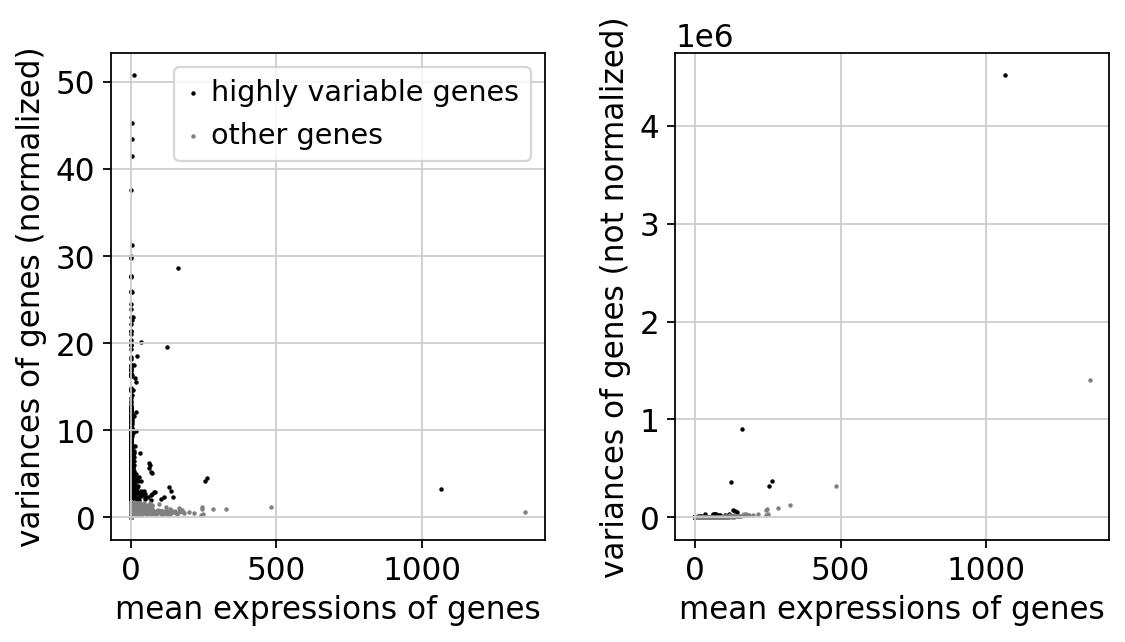

Total number of cells: 12520
Total number of genes: 3000


In [11]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(Trophoblasts, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(Trophoblasts)

#saving the highl variable genes
highly_variable_genesTrophoblasts = Trophoblasts.var["highly_variable"]
Trophoblasts = Trophoblasts[:, highly_variable_genesTrophoblasts]

print('Total number of cells: {:d}'.format(Trophoblasts.n_obs))
print('Total number of genes: {:d}'.format(Trophoblasts.n_vars))

In [12]:
#Trophoblasts.var.to_csv('../results/exp_infection/tables/highlyVariable_genesTrophoblasts.csv')

# Subsetting the trophoblasts



In [13]:
#set(adata_MFIRef.obs['cell_type'])

In [14]:
MFI_sub =adata_MFIRef[[ i in ['SCT','VCT_CCC','VCT_fusing','VCT_p','VCT',
                             'EVT_1','EVT_2','iEVT','eEVT'] for i in adata_MFIRef.obs.cell_type ]]

# LOGISTIC REGRESSION

### Subsetting both datasets' copies to common genes only

Can be either overlap of all genes that passed QC or HVG overlap

In [15]:
MFI_sub.var

,gene_ids-0,feature_types-0,genome-0,n_cells-0,gene_ids-1,feature_types-1,genome-1,n_cells-1,gene_ids-10,feature_types-10,...,genome-7,n_cells-7,gene_ids-8,feature_types-8,genome-8,n_cells-8,gene_ids-9,feature_types-9,genome-9,n_cells-9
A1BG,ENSG00000121410,Gene Expression,GRCh38,58.0,ENSG00000121410,Gene Expression,GRCh38,118.0,ENSG00000121410,Gene Expression,...,GRCh38,140.0,ENSG00000121410,Gene Expression,GRCh38,185.0,ENSG00000121410,Gene Expression,GRCh38,608.0
A1BG-AS1,ENSG00000268895,Gene Expression,GRCh38,7.0,ENSG00000268895,Gene Expression,GRCh38,21.0,ENSG00000268895,Gene Expression,...,GRCh38,14.0,ENSG00000268895,Gene Expression,GRCh38,20.0,ENSG00000268895,Gene Expression,GRCh38,91.0
A1CF,nan,nan,nan,NaN,nan,nan,nan,NaN,nan,nan,...,nan,NaN,nan,nan,nan,NaN,nan,nan,nan,NaN
A2M,ENSG00000175899,Gene Expression,GRCh38,66.0,ENSG00000175899,Gene Expression,GRCh38,171.0,ENSG00000175899,Gene Expression,...,nan,NaN,ENSG00000175899,Gene Expression,GRCh38,5.0,ENSG00000175899,Gene Expression,GRCh38,2117.0
A2M-AS1,ENSG00000245105,Gene Expression,GRCh38,6.0,ENSG00000245105,Gene Expression,GRCh38,5.0,ENSG00000245105,Gene Expression,...,GRCh38,59.0,ENSG00000245105,Gene Expression,GRCh38,61.0,ENSG00000245105,Gene Expression,GRCh38,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,ENSG00000070476,Gene Expression,GRCh38,11.0,ENSG00000070476,Gene Expression,GRCh38,21.0,ENSG00000070476,Gene Expression,...,GRCh38,26.0,ENSG00000070476,Gene Expression,GRCh38,32.0,ENSG00000070476,Gene Expression,GRCh38,122.0
ZYG11A,nan,nan,nan,NaN,nan,nan,nan,NaN,nan,nan,...,nan,NaN,nan,nan,nan,NaN,nan,nan,nan,NaN
ZYG11B,ENSG00000162378,Gene Expression,GRCh38,15.0,ENSG00000162378,Gene Expression,GRCh38,41.0,ENSG00000162378,Gene Expression,...,GRCh38,22.0,ENSG00000162378,Gene Expression,GRCh38,47.0,ENSG00000162378,Gene Expression,GRCh38,183.0
ZYX,ENSG00000159840,Gene Expression,GRCh38,134.0,ENSG00000159840,Gene Expression,GRCh38,284.0,ENSG00000159840,Gene Expression,...,GRCh38,265.0,ENSG00000159840,Gene Expression,GRCh38,319.0,ENSG00000159840,Gene Expression,GRCh38,2351.0


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/opt/conda/envs/scvi-singularity/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


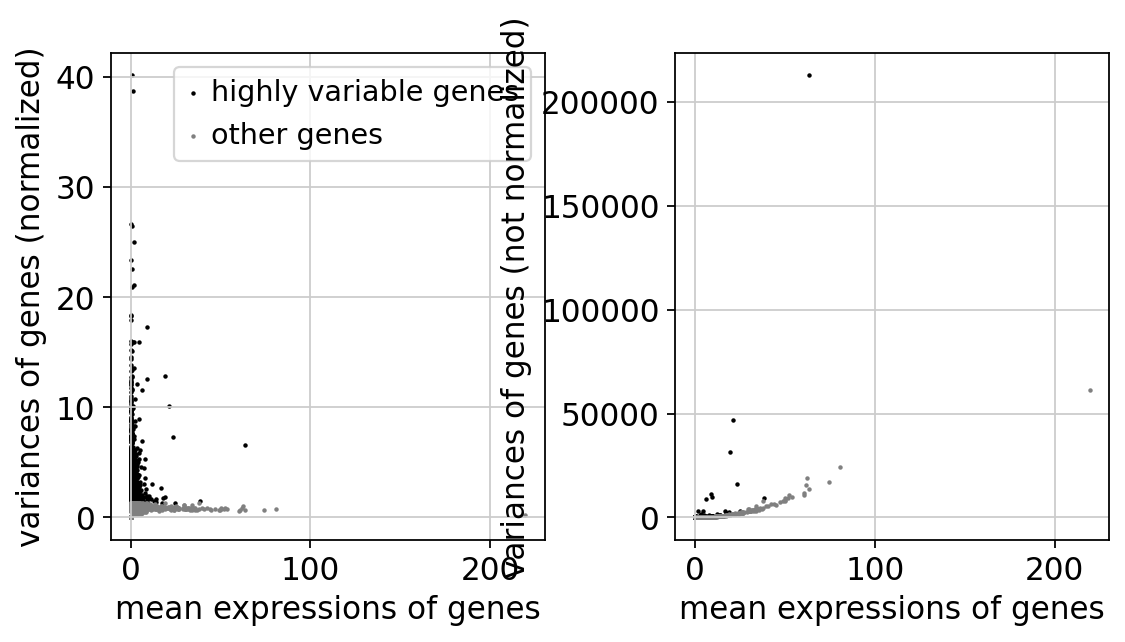

Total number of cells: 75023
Total number of genes: 3000


In [16]:
sc.pp.highly_variable_genes(MFI_sub, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(MFI_sub)

#saving the highl variable genes
highly_variable_genes = MFI_sub.var["highly_variable"]
MFI_downsampled = MFI_sub[:, highly_variable_genes]

print('Total number of cells: {:d}'.format(MFI_downsampled.n_obs))
print('Total number of genes: {:d}'.format(MFI_downsampled.n_vars))

In [17]:
adata_hvg=Trophoblasts.copy()

In [18]:

print('Total number of cells: {:d}'.format(adata_hvg.n_obs))
print('Total number of genes: {:d}'.format(adata_hvg.n_vars))

Total number of cells: 12520
Total number of genes: 3000


In [19]:
# here using only HVG overlap

# normlog, scaled and HVG subsetted 
adata_train = MFI_downsampled.copy()
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.scale(adata_train, max_value=10)

# normlog, scaled and HVG subsetted 
adata_test = adata_hvg.copy()
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.scale(adata_test, max_value=10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [20]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between annotated train and our joint data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

1455 genes are shared between annotated train and our joint data 
 3000 genes in training data 
 3000 genes in test joint data 



In [21]:
#Subseting the datasets
adata_train_copy = adata_train[:,common_genes]
adata_train_copy.var_names

Index(['AADACL2-AS1', 'AADACL3', 'AADAT', 'ABCB1', 'ABCC11', 'ABCC9', 'ABCG1',
       'ABLIM2', 'ABTB2', 'AC000061.1',
       ...
       'ZFP36', 'ZNF114', 'ZNF117', 'ZNF208', 'ZNF365', 'ZNF367', 'ZNF704',
       'ZNF804A', 'ZNRF3', 'ZWINT'],
      dtype='object', length=1455)

In [22]:
#Subseting the datasets
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['AADACL2-AS1', 'AADACL3', 'AADAT', 'ABCB1', 'ABCC11', 'ABCC9', 'ABCG1',
       'ABLIM2', 'ABTB2', 'AC000061.1',
       ...
       'ZFP36', 'ZNF114', 'ZNF117', 'ZNF208', 'ZNF365', 'ZNF367', 'ZNF704',
       'ZNF804A', 'ZNRF3', 'ZWINT'],
      dtype='object', length=1455)

In [23]:
# checking gene correspondence - important!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [24]:
adata_train_copy.obs

,n_genes,sample,technology,tissue,dev_age,donor,dataset,run,number_of_individuals_multiplexed,batch,percent_mito,n_counts,scrublet_score,scrublet_cluster_score,bh_pval,is_doublet,cell_type
barcode_sample,,,,,,,,,,,,,,,,,
AGGGTGAGTAAAGGAG-1_FCA7167219,5291,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,0,0.019406,35504.0,0.186441,0.118367,0.857143,False,VCT
CTGATAGAGCCCAGCT-1_FCA7167219,4070,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,0,0.027002,14851.0,0.186441,0.118367,0.857143,False,EVT_2
GCGCGATAGATATGGT-1_FCA7167219,506,FCA7167219,10X_3'_scRNA-seq,decidua_immune,13_PCW,6,Vento_Nature,NaN,1,0,0.005571,1077.0,0.212500,0.118367,0.857143,False,SCT
ATTACTCTCTGCGGCA-1_FCA7167221,655,FCA7167221,10X_3'_scRNA-seq,decidua_immune,11_PCW,7,Vento_Nature,NaN,1,1,0.003621,1657.0,0.175000,0.167267,0.242677,False,iEVT
CTGATAGAGCCCAGCT-1_FCA7167221,412,FCA7167221,10X_3'_scRNA-seq,decidua_immune,11_PCW,7,Vento_Nature,NaN,1,1,0.044892,646.0,0.090426,0.167267,0.242677,False,EVT_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATGGCCTG-1_Pla_Camb10714920,4195,Pla_Camb10714920,10X_multiome,decidua_placenta_myometrium,8-9_PCW,P13,Ashley_collection_sn,NaN,1,61,0.001670,25749.0,0.120760,0.139013,0.833970,False,SCT
TTTGTGTTCGCTCACT-1_Pla_Camb10714920,1629,Pla_Camb10714920,10X_multiome,decidua_placenta_myometrium,8-9_PCW,P13,Ashley_collection_sn,NaN,1,61,0.008763,2853.0,0.031335,0.036295,0.999631,False,VCT
TTTGTGTTCTTAGTCT-1_Pla_Camb10714920,4129,Pla_Camb10714920,10X_multiome,decidua_placenta_myometrium,8-9_PCW,P13,Ashley_collection_sn,NaN,1,61,0.002532,17379.0,0.102190,0.125000,0.886380,False,SCT


In [25]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['EVT_1', 'EVT_2', 'SCT', 'VCT', 'VCT_CCC', 'VCT_fusing', 'VCT_p',
        'eEVT', 'iEVT'], dtype=object),
 array([ 5289,  2358, 28177, 23472,  3373,  1971,  6679,    28,  3676]))

## Training a logistic regression model on previously annotated MFI reference by Anna

In [26]:
adata_train_copy.obs['cell_type'].head()

barcode_sample
AGGGTGAGTAAAGGAG-1_FCA7167219      VCT
CTGATAGAGCCCAGCT-1_FCA7167219    EVT_2
GCGCGATAGATATGGT-1_FCA7167219      SCT
ATTACTCTCTGCGGCA-1_FCA7167221     iEVT
CTGATAGAGCCCAGCT-1_FCA7167221    EVT_2
Name: cell_type, dtype: category
Categories (9, object): ['EVT_1', 'EVT_2', 'SCT', 'VCT', ..., 'VCT_fusing', 'VCT_p', 'eEVT', 'iEVT']

In [27]:
celltypes_train = adata_train_copy.obs['cell_type']

In [28]:
adata_train_copy.X.shape

(75023, 1455)

# The following cell actually trains the model and may require quite a bit of time if you are using a big training dataset

In [ ]:
#12:15
%time
# training a logistic regression model on scRNA-seq data
# takes about 15min for HVGs intersection of trophoblasts (~12k cells)
logisticRegr_sc = LogisticRegression(max_iter = 5000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr_sc.fit(adata_train_copy.X, celltypes_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [ ]:
# Saving model

#pkl_filename = "./logreg_from_P13_downsampled_no_soupy_genes_coarse_troph_to_all_troph_organoids_premrna_HVGs.pkl"
pkl_filename = "../results/log_regression/logreg_trophoblastOnly_to_explant_HVGs_20230707_48h.pkl"



with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr_sc, file)

In [ ]:
# Load model (scRNA-seq) from file

# which one?
#pkl_filename = "../results/log_regression/logreg_trophoblastOnly_to_explant_premrna_HVGs_20220523.pkl"

#with open(pkl_filename, 'rb') as file:  
#    logisticRegr_sc = pickle.load(file)

In [ ]:
logisticRegr_sc

In [ ]:
%%time
predictions = logisticRegr_sc.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions'] = predictions

In [ ]:
%%time
# probabilities
probabilities = logisticRegr_sc.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions']):
    probs_adata.append(probabilities[i,logisticRegr_sc.classes_==clus][0])



In [ ]:
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

In [ ]:
adata_test_copy.obs['celltype_predictions']

In [ ]:
# now you can return to your object transferring celltype predictions and their probabilities from training

# my test object
Trophoblasts.obs['celltype_predictions'] = adata_test_copy.obs.loc[Trophoblasts.obs_names,'celltype_predictions']
Trophoblasts.obs['probabilities'] = probs_adata

In [ ]:
# you may want to save results at this point
Trophoblasts.obs.loc[:,['celltype_predictions','probabilities']].to_csv('../results/log_regression/logreg_trophoblastOnly_to_explant_HVGs_predictions_20230707_48h.csv')

